<a href="https://colab.research.google.com/github/charishmap18/test/blob/main/without_bN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Requried libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from dataset import VOCDataset
from utils import non_max_suppression,cellboxes_to_boxes

In [ ]:
#YOLO-V1 Neural Network
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, split_size=7, num_boxes=2, num_classes=20):
        super(Yolov1, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),

            # Block 2
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),

            # Block 3
            nn.Conv2d(192, 128, kernel_size=1),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=1),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),

            # Block 4
            nn.Conv2d(512, 256, kernel_size=1),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, kernel_size=1),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, kernel_size=1),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, kernel_size=1),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),

            nn.Conv2d(512, 512, kernel_size=1),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2)),

            # Block 5
            nn.Conv2d(1024, 512, kernel_size=1),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, kernel_size=1),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),

            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),

            # Block 6
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),

            # Block 7
            nn.Flatten(),         #flatten into 1D tensor
            nn.Linear(1024 * split_size**2, 400),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(400, split_size**2 * (num_classes + num_boxes*5))   #a linear layer which predicts the class probabilities and bounding boxes for each grid cell.
        )
      
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
mse = nn.MSELoss(reduction='sum') #mean squared error loss function

In [ ]:
# Input a tensor of bounding boxes(x, y, w, h) and returns four tensors - left x, right x, top y, and bottom y coordinates of the boxes.
def get_margin_box(box):
    mid_x = box[..., 0:1]
    mid_y = box[..., 1:2]
    half_width = box[..., 2:3] / 2
    half_height = box[..., 3:4] / 2
    left_x = mid_x - half_width
    right_x = mid_x + half_width
    top_y = mid_y - half_height
    bot_y = mid_y + half_height
    return left_x, right_x, top_y, bot_y

# computes the IoU metric between the two boxes
def IoU(left_x1, right_x1, top_y1, bot_y1, left_x2, right_x2, top_y2, bot_y2):
    left_x_inte = torch.max(left_x1, left_x2)
    right_x_inte = torch.min(right_x1, right_x2)
    top_y_inte = torch.max(top_y1, top_y2)
    bot_y_inte = torch.min(bot_y1, bot_y2)
    intersection = (right_x_inte - left_x_inte).clamp(0) * (bot_y_inte - top_y_inte).clamp(0)
    box1_area = abs((right_x1 - left_x1) * (bot_y1 - top_y1))
    box2_area = abs((right_x2 - left_x2) * (bot_y2 - top_y2))
    union = box1_area + box2_area - intersection + 1e-6
    return intersection/union
    
# find better box based on iou metric
def find_better_box(pred, target):
    left_x1, right_x1, top_y1, bot_y1 = get_margin_box(pred[..., 21:25])
    left_x2, right_x2, top_y2, bot_y2 = get_margin_box(pred[..., 26:30])
    left_x_target, right_x_target, top_y_target, bot_y_target = get_margin_box(target[..., 21:25])
    
    iou1 = IoU(left_x1, right_x1, top_y1, bot_y1, left_x_target, right_x_target, top_y_target, bot_y_target)
    iou2 = IoU(left_x2, right_x2, top_y2, bot_y2, left_x_target, right_x_target, top_y_target, bot_y_target)
    ious = torch.cat([iou1.unsqueeze(3), iou2.unsqueeze(3)], dim=3)
    return torch.argmax(ious, dim=3)

In [ ]:
# Loss: Coordinates of boxes
def loss_coord(pred, target, exists_box, better_box):
    pred = exists_box * (better_box * pred[..., 26:28] + (1-better_box) * pred[..., 21:23])
    target = exists_box * target[..., 21:23]
    return mse(pred, target)

In [ ]:
# Loss: Size of boxes
def loss_size(pred, target, exists_box, better_box):
    pred = exists_box * (better_box * pred[..., 28:30] + (1-better_box) * pred[..., 23:25])
    target = exists_box * target[..., 23:25]
    pred = torch.sign(pred) * torch.sqrt(torch.abs(pred) + 1e-6)
    target = torch.sqrt(target)
    return mse(pred, target)

In [ ]:
# Loss: Prob of containing object
def loss_object(pred, target, exists_box, better_box):
    pred = exists_box * (better_box * pred[..., 25:26] + (1-better_box) * pred[..., 20:21])
    target = exists_box * target[..., 20:21]
    return mse(pred, target)

In [ ]:
# Loss function: Prob of not containing object(Penalize both bounding boxes)
def loss_no_object(pred, target, exists_box, better_box):
    pred1 = (1-exists_box) * pred[..., 20:21]
    pred2 = (1-exists_box) * pred[..., 25:26]
    target = (1-exists_box) * target[..., 20:21]
    return mse(pred1, target) + mse(pred2, target)

In [ ]:
# Loss: Prob of each class
def loss_class(pred, target, exists_box, better_box):
    pred = exists_box * pred[..., :20]
    target = exists_box * target[..., :20]
    return mse(pred, target)

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self, split_size=7, num_boxes=2, num_classes=20):
        super(YoloLoss, self).__init__()
        self.split = split_size
        self.boxes = num_boxes
        self.classes = num_classes
        self.lambda_coord = 5
        self.lambda_noobj = 0.5
    # Target -> ground truth; pred -> prdicted output 
    def forward(self, pred, target):
        pred = pred.reshape(-1, self.split, self.split, self.classes + self.boxes * 5)
        better_box = find_better_box(pred, target)
        exists_box = target[..., 20:21]
        coord_loss = loss_coord(pred, target, exists_box, better_box) # the loss for the bounding box coordinates
        size_loss = loss_size(pred, target, exists_box, better_box)   # the loss for the size of the selected box
        object_loss = loss_object(pred, target, exists_box, better_box) # the loss for the probability that an object exists in the cell
        no_object_loss = loss_no_object(pred, target, exists_box, better_box)
        class_loss = loss_class(pred, target, exists_box, better_box)   #the loss for the predicted probability distribution over object classes
        loss = self.lambda_coord * (coord_loss + size_loss) + object_loss + self.lambda_noobj * no_object_loss + class_loss
        return loss

In [ ]:
# takes in a list of transformations and applies them to both the input image and the target.
class JointCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img), target
        return img, target
    
transform = JointCompose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [ ]:
# Train function
# DEVICE = "cpu"
DEVICE = "cuda"  # Can switch to GPU by simply uncomment this line

def train(dataloader, model, optimizer, loss_fn):
    sum_loss = 0
    pbar = tqdm(dataloader, leave = False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        sum_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return sum_loss / (batch+1)

In [ ]:
# Test function
def test(dataloader, model, optimizer, loss_fn):
    sum_loss = 0
    pbar = tqdm(dataloader, leave = False)
    with torch.no_grad():
        for batch, (x, y) in enumerate(pbar):
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            loss = loss_fn(pred, y)
            sum_loss += loss.item()
    return sum_loss / (batch+1)

In [ ]:
# Develop a function to plot the bounding box, predicted label and predicted probability
LABEL = ["airplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "dining table",
"dog", "horse", "motorbike", "person", "potted plant", "sheep", "sofa", "train", "TV monitor"]
LABEL_COLOR = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', 
               '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_image(image, boxes, ax):
    im = np.array(image)
    height, width, _ = im.shape
    ax.imshow(im)

    for box in boxes:
        obj = int(box[0])
        prob = box[1]
        prob = max(0, min(1, prob))

        topleft_x = box[2] - box[4] / 2
        topleft_y = box[3] - box[5] / 2
        rect = patches.Rectangle(
            (topleft_x * width, topleft_y * height),
            box[4] * width,
            box[5] * height,
            linewidth=2,
            edgecolor=LABEL_COLOR[obj],
            facecolor="none",
        )
        ax.annotate('{}: {:.2f}'.format(LABEL[obj], prob), 
                    (topleft_x * width+5, topleft_y * height-10), 
                    backgroundcolor=LABEL_COLOR[obj])
        ax.add_patch(rect)

Importing Data set

In [ ]:
# upload kaggle.json file for allowing program to access kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"deepikanarne","key":"eed28b89dcbdfa1f8dfa6e0b32eb942f"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aladdinpersson/pascal-voc-dataset-used-in-yolov3-video

100% 4.30G/4.31G [02:17<00:00, 30.4MB/s]
100% 4.31G/4.31G [02:17<00:00, 33.7MB/s]


In [ ]:
!unzip pascal-voc-dataset-used-in-yolov3-video.zip

Streaming output truncated to the last 5000 lines.
  inflating: PASCAL_VOC/labels/2009_004289.txt  
  inflating: PASCAL_VOC/labels/2009_004290.txt  
  inflating: PASCAL_VOC/labels/2009_004291.txt  
  inflating: PASCAL_VOC/labels/2009_004295.txt  
  inflating: PASCAL_VOC/labels/2009_004298.txt  
  inflating: PASCAL_VOC/labels/2009_004300.txt  
  inflating: PASCAL_VOC/labels/2009_004301.txt  
  inflating: PASCAL_VOC/labels/2009_004303.txt  
  inflating: PASCAL_VOC/labels/2009_004307.txt  
  inflating: PASCAL_VOC/labels/2009_004308.txt  
  inflating: PASCAL_VOC/labels/2009_004309.txt  
  inflating: PASCAL_VOC/labels/2009_004312.txt  
  inflating: PASCAL_VOC/labels/2009_004315.txt  
  inflating: PASCAL_VOC/labels/2009_004316.txt  
  inflating: PASCAL_VOC/labels/2009_004317.txt  
  inflating: PASCAL_VOC/labels/2009_004319.txt  
  inflating: PASCAL_VOC/labels/2009_004322.txt  
  inflating: PASCAL_VOC/labels/2009_004323.txt  
  inflating: PASCAL_VOC/labels/2009_004324.txt  
  inflating: PASCA

In [ ]:
seed = 684
torch.manual_seed(seed)

LEARNING_RATE = 2e-5
BATCH_SIZE = 16 # 64 in original paper
WEIGHT_DECAY = 0.0005
EPOCHS = 20
IMG_DIR = "PASCAL_VOC/images"
LABEL_DIR = "PASCAL_VOC/labels"

In [ ]:
# Load Dataset
small_train_dataset = VOCDataset("PASCAL_VOC/1examples.csv", transform=transform,img_dir=IMG_DIR,label_dir=LABEL_DIR)
large_train_dataset = VOCDataset("PASCAL_VOC/train.csv", transform=transform,img_dir=IMG_DIR,label_dir=LABEL_DIR)
test_dataset = VOCDataset("PASCAL_VOC/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)

small_train_loader = DataLoader(dataset=small_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
large_train_loader = DataLoader(dataset=large_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## a. Create overfit_model and train it on the single image dataset.


In [ ]:
%matplotlib notebook

overfit_model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

overfit_loss = []
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    loss = train(small_train_loader, overfit_model, optimizer, loss_fn)
    overfit_loss.append(loss)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
pbar = tqdm(range(1))
for epoch in pbar:
    overfit_loss_test = test(test_loader, overfit_model, optimizer, loss_fn)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

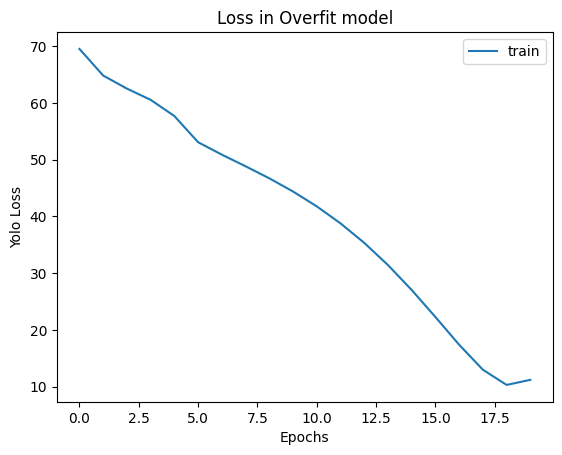

In [ ]:
%matplotlib inline

plt.plot(overfit_loss, label="train")
plt.xlabel("Epochs")
plt.ylabel("Yolo Loss")
plt.title("Loss in Overfit model")
plt.legend()
plt.show()

### (ii) Yolo Loss in test dataset

In [ ]:
print("The loss in training set is {:.2f} while the loss in test set is {:.2f}".format(overfit_loss[-1], overfit_loss_test))

The loss in training set is 11.20 while the loss in test set is 1488.33


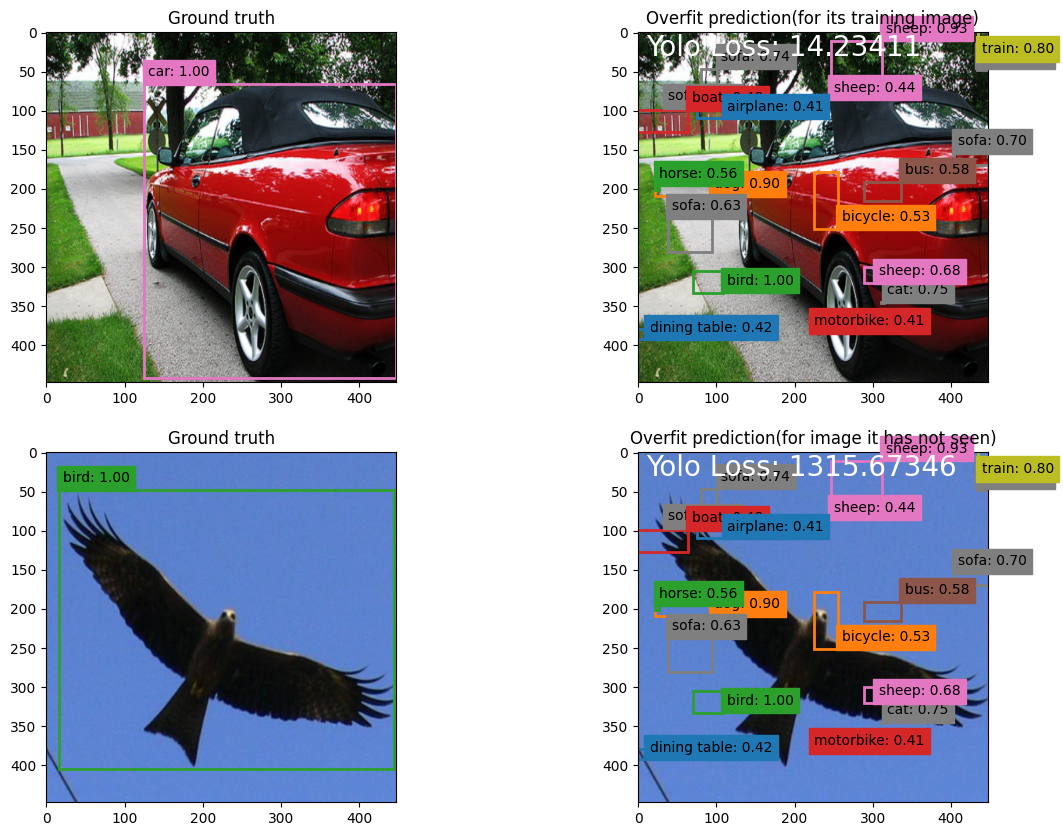

In [ ]:
fig = plt.figure(figsize=(14,10))
for x, y in small_train_loader:
    for i in range(1):
        ax1 = fig.add_subplot(2,2,1)
        plt.title("Ground truth")
        x, y = x.to(DEVICE), y.to(DEVICE)
        bboxes = cellboxes_to_boxes(y)
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax1)
        
        ax2 = fig.add_subplot(2,2,2)
        plt.title("Overfit prediction(for its training image)")
        bboxes = cellboxes_to_boxes(overfit_model(x))
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax2)

    pred = overfit_model(x)
    loss = loss_fn(pred, y)
    ax2.text(10, 30, 'Yolo Loss: {:.5f}'.format(loss.item()), fontsize=20, color='white')
    break

for x, y in test_loader:
    for i in range(1):
        ax3 = fig.add_subplot(2,2,3)
        plt.title("Ground truth")
        x, y = x.to(DEVICE), y.to(DEVICE)
        bboxes = cellboxes_to_boxes(y)
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax3)
        ax4 = fig.add_subplot(2,2,4)
        plt.title("Overfit prediction(for image it has not seen)")
        bboxes = cellboxes_to_boxes(overfit_model(x))
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax4)
    pred = overfit_model(x)
    loss = loss_fn(pred, y)
    ax4.text(10, 30, 'Yolo Loss: {:.5f}'.format(loss.item()), fontsize=20, color='white')
    break

In [ ]:
%matplotlib notebook

EPOCHS = 20
trained_model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = torch.optim.Adam(trained_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()
trained_loss = []
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    loss = train(large_train_loader, trained_model, optimizer, loss_fn)
    trained_loss.append(loss)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

  0%|          | 0/1035 [00:00<?, ?it/s]

In [ ]:
pbar = tqdm(range(1))
for epoch in pbar:
    trained_loss_test = test(test_loader, trained_model, optimizer, loss_fn)

In [ ]:
%matplotlib inline

plt.plot(trained_loss, label="train")
plt.xlabel("Epochs")
plt.ylabel("Yolo Loss")
plt.title("Loss in Trained model")
plt.legend()
plt.show()

### (ii) Yolo Loss in test dataset

In [ ]:
print("The loss in training set is {:.2f} while the loss in test set is {:.2f}".format(trained_loss[-1], trained_loss_test))

In [ ]:
fig = plt.figure(figsize=(8,8))
for x, y in large_train_loader:
    for i in range(1):
        ax1 = fig.add_subplot(2,2,1)
        plt.title("Ground truth")
        x, y = x.to(DEVICE), y.to(DEVICE)
        bboxes = cellboxes_to_boxes(y)
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax1)
        
        ax2 = fig.add_subplot(2,2,2)
        plt.title("Trained prediction(for its training image)")
        bboxes = cellboxes_to_boxes(trained_model(x))
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax2)
    pred = trained_model(x)
    loss = loss_fn(pred, y)
    ax2.text(10, 30, 'Yolo Loss: {:.5f}'.format(loss.item()), fontsize=20, color='white')
    break

for x, y in test_loader:
    for i in range(1):
        ax3 = fig.add_subplot(2,2,3)
        plt.title("Ground truth")
        x, y = x.to(DEVICE), y.to(DEVICE)
        bboxes = cellboxes_to_boxes(y)
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax3)
        ax4 = fig.add_subplot(2,2,4)
        plt.title("Trained prediction(for image it has not seen)")
        bboxes = cellboxes_to_boxes(trained_model(x))
        bboxes = non_max_suppression(bboxes[i], iou_threshold=0.5, threshold=0.3, box_format="midpoint")
        plot_image(x[i].permute(1,2,0).to("cpu"), bboxes, ax4)
    pred = trained_model(x)
    loss = loss_fn(pred, y)
    ax4.text(10, 30, 'Yolo Loss: {:.5f}'.format(loss.item()), fontsize=20, color='white')
    break